<a href="https://colab.research.google.com/github/JohnnyWang1998/electricity_price_prediction/blob/main/IDMP_Project_Johnny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [38]:
from typing import List
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [39]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [40]:
import lightgbm as lgb

In [41]:
class DataModeler:
    def __init__(self):
        pass

    def _parametrized(dec):
        def layer(*args, **kwargs):
            def repl(f):
                return dec(f, *args, **kwargs)
            return repl
        return layer

    @staticmethod
    @_parametrized
    def logger(f, job):
        def aux(self, *xs, **kws):
            print(job + "...", end='\t')
            res = f(self, *xs, **kws)
            print("Done")
            return res
        return aux

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
data_dir = '/content/drive/MyDrive/5110_final_project/'
df_energy = pd.read_csv(data_dir + 'energy_dataset.csv')
df_weather = pd.read_csv(data_dir + 'weather_features.csv')
# df_energy = pd.read_csv('/energy_dataset.csv')
# df_weather = pd.read_csv('/weather_features.csv')

In [44]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [45]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [111]:
class DataPreprocessor(DataModeler):
    "Wrap the operations of data preprocessing."
    
    def __init__(self):
        super(DataPreprocessor, self).__init__()

    @DataModeler.logger("Foramtting feature namne")
    def _format_feat_name(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Format feature name
        @param df: Dataframe
        return: precessed dataframe
        """
        d = {x:'_'.join(x.split()) for x in df.columns}
        df = df.rename(columns=d)
        return df

    @DataModeler.logger("Filling missing value")
    def _fill_missing_value(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Fill missing values in input data.
        @param df: dataframe
        return: processed dataframe
        """
        # res = df.fillna(method='ffill')

        # linear imputation filling
        res = df.copy()
        res.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)
        return res
    
    @DataModeler.logger("Replacing outliers")
    def _replace_outliers(self, df:pd.DataFrame) -> pd.DataFrame:
        res = df.copy()
        # outliers of wind_speed
        res.loc[res.wind_speed > 50, 'wind_speed'] = np.nan
        # outliers of pressure
        res.loc[res.pressure > 1051, 'pressure'] = np.nan
        res.loc[res.pressure < 931, 'pressure'] = np.nan
        return res

    @DataModeler.logger("Transforming feature type")
    def _trans_feat_type(self, df_energy:pd.DataFrame, df_weather:pd.DataFrame) -> List[pd.DataFrame]:
        """
        Transform data type of some columns.
        @param df_energy: energy data
        @param df_weather: weather data
        return: processed data
        """
        df_energy['time'] = pd.to_datetime(df_energy['time'])
        df_weather['time'] = pd.to_datetime(df_weather['time'])

        return df_energy, df_weather


    @DataModeler.logger("Combining weather data")
    def _combine_weather_data(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Combine weather data from different cities so that 
            it can be joined on the energy data.
        @param df: dataframe
        return: processed dataframe
        """
        num_feats = [
            'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 
            'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 
            'snow_3h', 'clouds_all'
        ]
        res = df[num_feats+['time']].groupby(['time'], as_index=False).mean()
        return res
    
    def preprocess(self, df_energy_:pd.DataFrame, df_weather_:pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess energy data and weather data and then join them together.
        @param df_energy_: energy data
        @param df_weather_: weather data
        return: combined clean energy and weather data
        """
        df_energy = df_energy_.copy()
        df_weather = df_weather_.copy()
        df_weather = df_weather.rename(columns={'dt_iso':'time'})

        # replace the outliers in weather data
        df_weather = self._replace_outliers(df_weather)

        #* Fill missing value
        df_weather = self._fill_missing_value(df_weather)
        df_energy = self._fill_missing_value(df_energy)

        #* Drop invalid columns
        cols_to_drop = ['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'] +\
                        ['generation fossil coal-derived gas', 'generation wind offshore', 'generation fossil oil shale', 
                        'generation fossil peat', 'generation geothermal', 'generation marine']
        df_energy = df_energy.drop(cols_to_drop, axis=1)

        #* Combine weather data
        df_weather = self._combine_weather_data(df_weather)

        # #* Join energy data and weather data
        df = pd.merge(df_energy, df_weather, on=['time'])
        df['time'] = pd.to_datetime(df['time'], utc=True)
        df = df.sort_values(by='time', ascending=True).reset_index(drop=True)
        
        #* Format feature name
        df = self._format_feat_name(df)


        df = df.set_index('time')

        df['price_tomorrow'] = df['price_actual'].shift(-1, freq='D')
        df = df.iloc[:-24]
        df = df.reset_index()
        return df

In [112]:
data_preprocessor = DataPreprocessor()
df = data_preprocessor.preprocess(df_energy, df_weather)

Replacing outliers...	Done
Filling missing value...	Done
Filling missing value...	Done
Combining weather data...	Done
Foramtting feature namne...	Done


# Feature Engineering

In [113]:
class FeatureEngineer(DataModeler):
    "Wrap the operations of feature engineering."
    
    def __init__(self):
        super(FeatureEngineer, self).__init__()
    
    @DataModeler.logger("Generating date features")
    def _gen_date_feats(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Extract date features from time of data
        @param df: Dataframe
        return:  dataframe with new features
        """
        df["year"]=df['time'].dt.year
        df["quarter"]=df['time'].dt.quarter
        df["month"]=df['time'].dt.month
        df["week"]=df['time'].dt.week
        df["hour"]=df['time'].dt.hour
        df['dayofweek'] = df['time'].dt.dayofweek
        df["dayofmonth"]=df['time'].dt.day
        df['is_weekend'] = np.where(df['time'].dt.day_name().isin(['Sunday', 'Saturday']), 1,0)
        df["is_year_start"]=df['time'].dt.is_year_start

        return df

    def generate_feats(self, df:pd.DataFrame) -> pd.DataFrame:
        """
        Generate new features.
        @param df: dataframe
        return: dataframe with new features
        """

        month = df['time'].dt.month

        # season feature
        # Set conditional satements for filtering times of month to season value
        condition_winter = (month>=1)&(month<=3)
        condtion_spring = (month>=4)&(month<=6)
        condition_summer = (month>=7)&(month<=9)
        condition_automn = (month>=10)@(month<=12)
        
        # Create column in dataframe that inputs the season based on the conditions created above
        df['season'] = np.where(condition_winter,0,
                                np.where(condtion_spring,1,
                                        np.where(condition_summer,2,
                                                np.where(condition_automn,3,np.nan))))



        df = self._gen_date_feats(df)

        return df

In [114]:
feat_engineer = FeatureEngineer()
df = feat_engineer.generate_feats(df)

Generating date features...	Done


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 43 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35040 non-null  datetime64[ns, UTC]
 1   generation_biomass                           35040 non-null  float64            
 2   generation_fossil_brown_coal/lignite         35040 non-null  float64            
 3   generation_fossil_gas                        35040 non-null  float64            
 4   generation_fossil_hard_coal                  35040 non-null  float64            
 5   generation_fossil_oil                        35040 non-null  float64            
 6   generation_hydro_pumped_storage_consumption  35040 non-null  float64            
 7   generation_hydro_run-of-river_and_poundage   35040 non-null  float64            
 8   generation_hydro_water_res

# Model Building

In [17]:
# stepwise selection
def get_auc(predictors, response, data):
    x = data[predictors]
    y = response
    # use lightGBM model to build the model
    model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42)
    model.fit(x,y,verbose=20,eval_metric='logloss')
    # predict the result and calculate the AUC value
    y_pred=model.predict(X_test[predictors])
    result_auc = 0.5
    try:
        result_auc = roc_auc_score(y_pred, y_test)
    except ValueError:
        pass
    if(result_auc == 0.9530040648142992):
        print(predictors)
        print(result_auc)
      
    return result_auc

def each_step(response, predictors, candidates, data):
    best_auc = -1
    best_candidate = None
    for i in candidates:
        auc_i = get_auc(predictors + [i], response, data)
        if(auc_i > best_auc):
            best_auc = auc_i
            best_candidate = i
    return best_candidate, best_auc

def step_wise(response, features, data):
    current_predictors = []
    best_auc = -1
    candidates = features.copy()
    for i in features:
        print(i)
        best = each_step(response, current_predictors, candidates, data)
        if(best[1] < best_auc):
            return current_predictors, best_auc
        best_auc = best[1]
        current_predictors = current_predictors + [best[0]]
        candidates = np.delete(candidates, np.where(candidates == best[0]))
    return current_predictors, best_auc


In [50]:
class Learner(DataModeler):
    def __init__(self):
        super(Learner, self).__init__()

        self.model_dict = {
            'LR':    {'class':LinearRegression,      'model':[]},
            'Ridge': {'class':Ridge,                 'model':[]},
            'Lasso': {'class':Lasso,                 'model':[]},
            'RF':    {'class':RandomForestRegressor, 'model':[]},
            'SVM':   {'class':SVR,                   'model':[]}
        }
    

    def train(self, df:pd.DataFrame, target:str, feats:List[str], nfold:int, model_name:str, model_param:dict, metric_func):
        """
        Model training
        @param df: trainset
        @param target: predicting target column name
        @param nfold: cross validation fold number
        @param feats: features to be used for training model
        @param model_name: model name, must be one of keys in model_dict
        @param model_param: model parameter dict
        @param metric_func: metric function
        """
        metric_l = []
        self.model_dict[model_name]['model'] = []

        for (trn_idx, val_idx) in tqdm(TimeSeriesSplit(nfold).split(df[feats]), total=nfold, desc="Training"):
            train_x = df.loc[trn_idx, feats]
            train_y = df.loc[trn_idx, target]
            valid_x = df.loc[val_idx, feats]
            valid_y = df.loc[val_idx, target]

            model = self.model_dict[model_name]['class'](**model_param).fit(train_x, train_y)
            valid_pred = model.predict(valid_x)
            metric = metric_func(valid_y, valid_pred)
            metric_l.append(metric)
            self.model_dict[model_name]['model'].append(model)
        
        print(f"{model_name} End of training, avg metric: {np.mean(metric_l)}")
    
    def _single_predict(self, df:pd.DataFrame, feats:List[str], model_name:str) -> np.array:
        """
        Use single model to predict
        @param df: testset
        @param feats: features used for training mdoel
        @param model_name: model name, must be one of keys in model_dict and has been trained
        return: prediction
        """
        pred_l = []
        for model in self.model_dict[model_name]['model']:
            pred_l.append(model.predict(df[feats].values).tolist())

        pred = np.mean(np.array(pred_l), axis=0)
        return pred
    
    def predict(self, df:pd.DataFrame, feats:List[str], models=None) -> np.array:
        """
        Use all the models that have been trained before to predict
        @param df: testset
        @param feats: features used for training mdoel
        @param models: list of model names to predict, if None then use all models
        return: prediction
        """
        pred_l = []
        if models is None:
            models = [x for x in self.model_dict.keys() if len(self.model_dict[x]['model'])>0]
        
        for model in tqdm(models, "Predicting"):
            tmp = self._single_predict(df, feats, model)
            pred_l.append(tmp.tolist())
        
        pred = np.mean(np.array(pred_l), axis=0)
        return pred

In [81]:
# step_wise(df_train[target], feats, df_train[feats])

In [51]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step=1):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        labels.append(target[i + target_size])

    return np.array(data), np.array(labels)

In [116]:
# test_idx = (df['time'].dt.year==2018) & (df['time'].dt.month.apply(lambda x: x in [9,10,11,12]))
test_idx = (df['time'].dt.year==2018)
df_train = df[~test_idx].reset_index(drop=True)
df_test = df[test_idx].reset_index(drop=True)
drop_feats = ['time', 'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead', 'total_load_forecast', 'price_day_ahead', 'price_tomorrow','price_actual']
feats = [x for x in df_train.columns if x not in drop_feats]
target = 'price_actual'

In [117]:
X = df[feats].values.astype('float32')
y = df[target].values.reshape(-1,1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_norm = scaler_X.fit_transform(X)
y_norm = scaler_y.fit_transform(y)

dataset_norm = np.concatenate((X_norm, y_norm), axis=1)

In [191]:
past_history = 24
future_target = 0
cv_end_idx = df.shape[0] - sum(df['time'].dt.year==2018)-past_history+1
train_end_idx = int(cv_end_idx*0.75)
test_end_idx = df.values.shape[0]

In [192]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target)

In [193]:
input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [194]:
learning_rate = 0.006

tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [195]:
batch_size = 32
buffer_size = 1000

In [196]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [197]:
history = multivariate_lstm.fit(train, epochs=50,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/50
616/616 [==============================] - 14s 20ms/step - loss: 0.3530 - root_mean_squared_error: 0.5941 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 2/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0057 - root_mean_squared_error: 0.0757 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 3/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0046 - root_mean_squared_error: 0.0681 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0650
Epoch 4/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 5/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0037 - root_mean_squared_error: 0.0604 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 6/50
616/616 [==============================] - 12s 19ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0

## predicting

In [198]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test.astype(np.float32))
lstm_forecast = scaler_y.inverse_transform(forecast)

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1,1))
rmse_lstm = mean_squared_error(y_test_inv, lstm_forecast, squared=False)
print('RMSE of hour-ahead electricity price LSTM forecast: {}'.format(rmse_lstm))

RMSE of hour-ahead electricity price LSTM forecast: 5.877429543237384


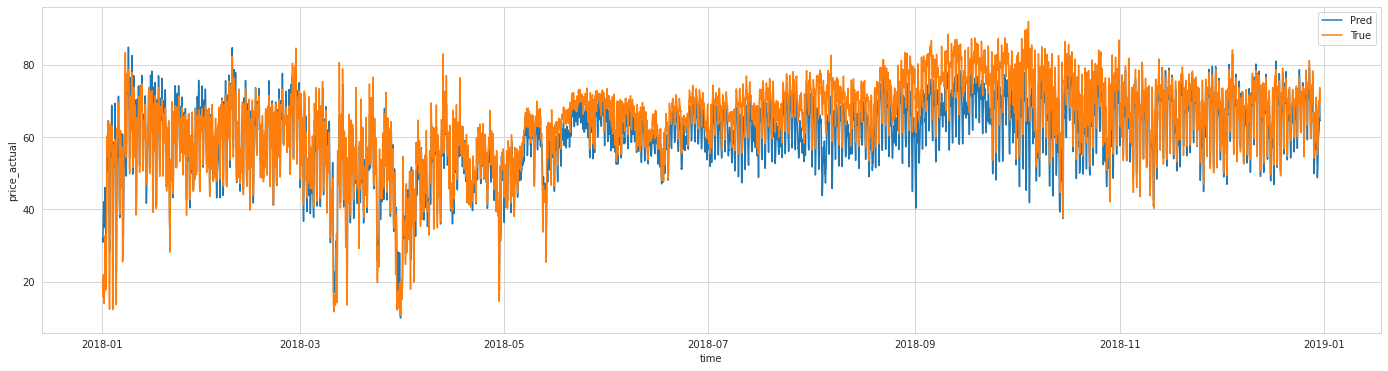

In [201]:
n = len(y_test_inv)
plt.figure(figsize=(24,6))
ax = plt.subplot(111)
sns.lineplot(x=df['time'][-n:], y=lstm_forecast[:,0], label='Pred', ax=ax)
sns.lineplot(x=df['time'][-n:], y=df[target][-n:], label='True', ax=ax)
sns.set_style("whitegrid")
plt.show()

In [202]:
trad_pred = pd.read_csv('/content/trad_pred.csv')
trad_pred.shape
new = trad_pred.values.reshape(-1)

In [199]:
lstm_forecast.shape

(8734, 1)

In [203]:
# get best rmse by adjusting the model weights
def best_rmse():
    best_rmse = 10000000000000
    best_split = 0
    for i in np.arange(0, 1, 0.0001):
        comb = (new*i + lstm_forecast.reshape(-1)*(1-i))
        this = mean_squared_error(y_test_inv, comb, squared=False)
        if this < best_rmse:
            best_rmse = this
            best_split = i
    return best_rmse, best_split

a, b = best_rmse()
print(a)
print(b)

4.278693225315567
0.6393


In [179]:
comb = (new*0.1 + lstm_forecast.reshape(-1)*0.9)

In [175]:
comb.shape

(8711,)

In [180]:
mean_squared_error(y_test_inv, comb, squared=False)

3.153965762432663

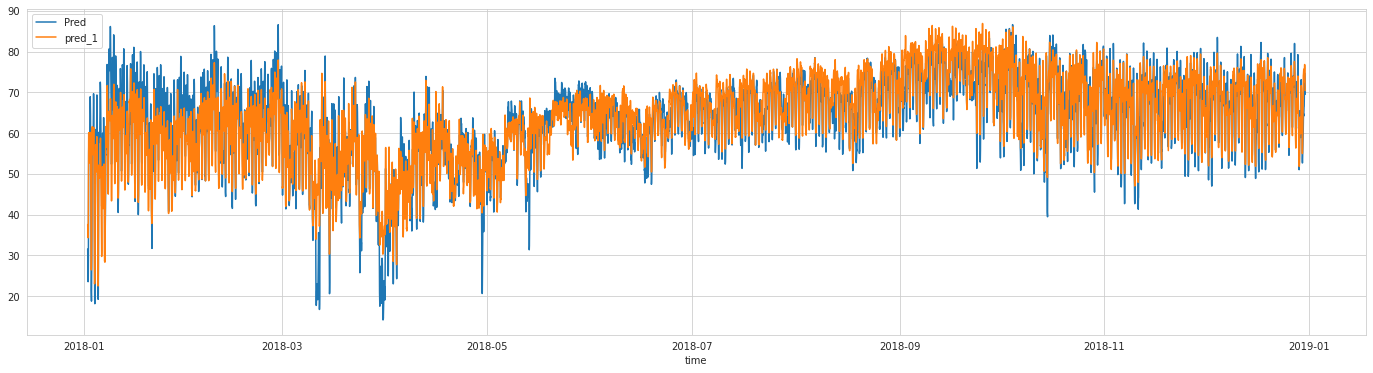

In [148]:
plt.figure(figsize=(24,6))
ax = plt.subplot(111)
sns.lineplot(x=df['time'][-n:], y=lstm_forecast[:,0], label='Pred', ax=ax)
sns.lineplot(x=df['time'][-n:], y=new, label='pred_1', ax=ax)
sns.set_style("whitegrid")
plt.show()

In [139]:
n

8711

In [138]:
lstm_forecast.shape

(8711, 1)

### Data split

## Baseline

In [ ]:
# Assign variables for baselines and calculate baselines
y_train= df_train[target]
y_pred = [y_train.mean()]*len(df_test[target])
mean_baseline_pred = y_train.mean()
baseline_rmse = mean_squared_error(df_test[target],y_pred,squared=False)

# Print statement to show all baseline values
print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
print('-------------------------------------------------------------------')
print('Baseline RMSE:',baseline_rmse)

Mean Price Per KW/h Baseline Pred: 55.995406576696595
-------------------------------------------------------------------
Baseline RMSE: 14.20246244284816


In [ ]:
learner = Learner()

In [ ]:
learner.train(df_train, target, feats, 5, 'LR', {}, mean_squared_error)
learner.train(df_train, target, feats, 5, 'Ridge', {}, mean_squared_error)
learner.train(df_train, target, feats, 5, 'Lasso', {}, mean_squared_error)
learner.train(df_train, target, feats, 5, 'RF', {}, mean_squared_error)

Training: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


LR End of training, avg metric: 462427.7377739272


Training: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Ridge End of training, avg metric: 97.5596367870129


Training: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Lasso End of training, avg metric: 59.43141004045735


Training: 100%|██████████| 5/5 [05:46<00:00, 69.32s/it]

RF End of training, avg metric: 73.38763360245392


In [ ]:
pred = learner.predict(df_test, feats, ['LR','Ridge','Lasso', 'RF'])
pred1 = learner.predict(df_test, feats, ['LR'])
pred2 = learner.predict(df_test, feats, ['Ridge'])
pred3 = learner.predict(df_test, feats, ['Lasso'])
pred4 = learner.predict(df_test, feats, ['RF'])

Predicting: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [ ]:
mean_squared_error(df_test[target], pred)

50133.91071228937

In [ ]:
mean_squared_error(df_test[target], pred1)

822405.291704983

In [ ]:
mean_squared_error(df_test[target], pred2)

77.48040041303582

In [ ]:
mean_squared_error(df_test[target], pred3)

72.78223074062969

In [ ]:
mean_squared_error(df_test[target], pred4)

45.911639175264284